# Optimal Step Nonrigid ICP Algorithms for Surface Registration


## The problem
Registering two surfaces means finding a mapping between a template surface and a target surface that describes
the position of semantically corresponding points. This can
be considered as warping the template onto the target.

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
plt.rcParams['figure.dpi'] = 160
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,  0]])

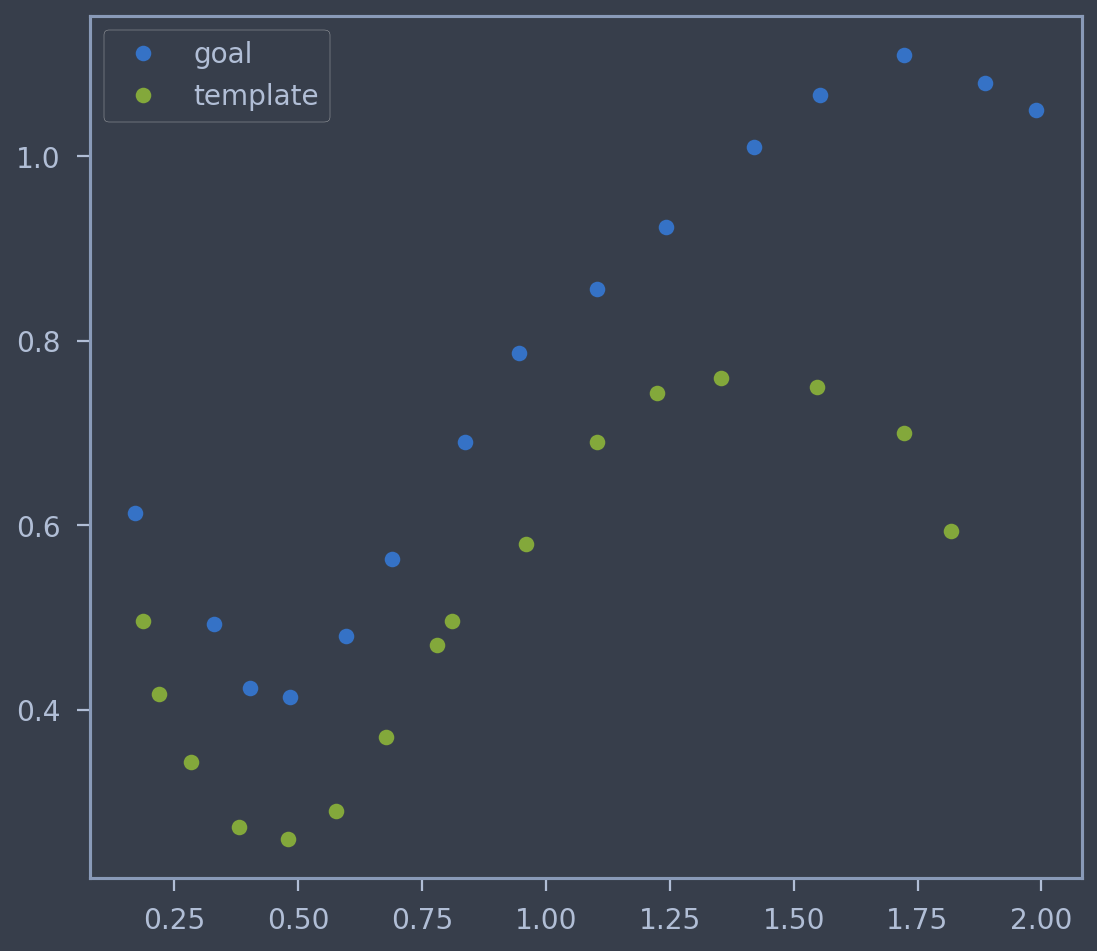

In [35]:
import numpy as np
scale = 1/300
goal = scale * np.array([(51,184), (99,148), (121,127), (145,124), (179,144), (207,169), (251,207), (284,236), (331,257), (373,277), (426,303), (466,320), (517,333), (566,324), (597,315)])
template = scale * np.array([(56,149), (66,125), (85,103), (114,82), (144,78), (173,87), (203,111), (234,141), (243,149), (288,174), (331,207), (367,223), (406,228), (464,225), (517,210), (545,178)])
edges = np.vstack([
    np.arange(len(template)),
    np.roll(np.arange(len(template)), -1)
]).T

plt.plot(goal[:, 0], goal[:, 1], 'o', label='goal')
plt.plot(template[:, 0], template[:, 1], 'o', label='template')
plt.legend()
edges.T

A template mesh $\mathcal{S} = (\mathcal{V, E})$ with vertices $\mathcal{V}$ and edges $\mathcal{E}$ is to be deformed to match a target surface $\mathcal{T}$. The target surface only needs to be defined in such a way that we can compute a distance from a point to it.

Each vertex $\boldsymbol{v}_i$ of the template has an associated affine transformation $\boldsymbol{X}_i$.

$$
\boldsymbol{X} = [\boldsymbol{X}_1 · · · \boldsymbol{X}_n]^T
$$

### The objective function

Minimize

$$
E(\boldsymbol{X}) = E_d(\boldsymbol{X}) + \alpha E_s(\boldsymbol{X}) + \beta E_l(\boldsymbol{X})
$$

Distance term

$$
E_d(\boldsymbol{X}) = \sum\limits_{\boldsymbol{v}_i \in \mathcal{V}} w_i \operatorname{dist}^2(\mathcal{T}, \boldsymbol{X}_i\boldsymbol{v}_i)
$$

Stiffness term

$$
E_s(\boldsymbol{X}) = \sum\limits_{(i, j) \in \mathcal{E}} \Vert (\boldsymbol{X}_i - \boldsymbol{X}_j)\boldsymbol{G} \Vert _F^2
$$

Landmark term

$$
E_l(\boldsymbol{X}) = \sum\limits_{(\boldsymbol{v}_i, \boldsymbol{l}) \in \mathcal{L}} \Vert (\boldsymbol{X}_i\boldsymbol{v}_i - \boldsymbol{l})\boldsymbol{G} \Vert ^2
$$

Computing closest point on target surface

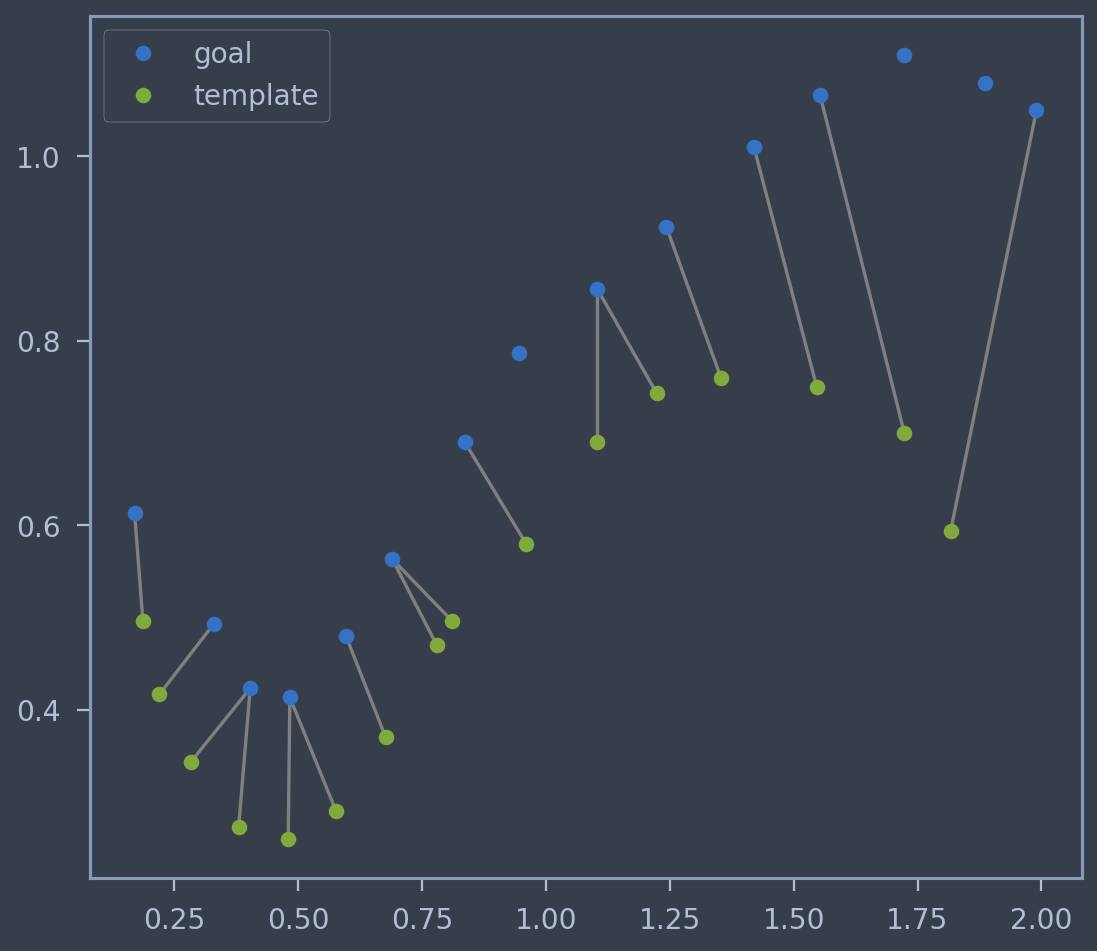

In [36]:
def closest_point(point, points):
    """Naive closest point"""
    dist2 = np.sum((np.asarray(points) - point)**2, axis=1)
    index = np.argmin(dist2)
    return points[index]


def find_correspondances(pts, goal):
    return np.vstack([closest_point(xv, goal) for xv in pts])

for v, u in zip(template, find_correspondances(template, goal)):
    plt.plot([v[0], u[0]], [v[1], u[1]], color='gray')

plt.plot(goal[:, 0], goal[:, 1], 'o', label='goal')
plt.plot(template[:, 0], template[:, 1], 'o', label='template')
plt.legend(); None

Distance term, but with fixed correspondences $(\boldsymbol{v}_i, \boldsymbol{u}_i)$
$$
\overline{E}_d(\boldsymbol{X}) = \sum\limits_{\boldsymbol{v}_i \in \mathcal{V}} w_i \Vert \boldsymbol{X}_i\boldsymbol{v}_i - \mathbf{u}_i \Vert ^2
$$

#### Re-arranging the distance term
Defining $\boldsymbol{W} = \operatorname{diag}(w_1, \dots, w_n)$ we can write it like so
$$
\overline{E}_d(\boldsymbol{X}) = \left\Vert (\boldsymbol{W} \otimes \boldsymbol{I}_3) \left(
\begin{bmatrix}
\boldsymbol{X}_1 & & \\
& \ddots & \\
& & \boldsymbol{X}_n 
\end{bmatrix}
\begin{bmatrix} \boldsymbol{v}_1 \\ \vdots \\ \boldsymbol{v}_n \end{bmatrix}
-
\begin{bmatrix} \boldsymbol{u}_1 \\ \vdots \\ \boldsymbol{u}_n \end{bmatrix}
\right) \right\Vert ^2
$$

This is unpractical to differentiate, but it can be arranged if we define
$\boldsymbol{U} = \begin{bmatrix} u_1 \dots u_n \end{bmatrix}$
and
$$
D = \begin{bmatrix}
\boldsymbol{v}^\top_1 & & \\
& \ddots & \\
& & \boldsymbol{v}^\top_n
\end{bmatrix}
$$

It's possible to write as
$$
\overline{E}_d(\boldsymbol{X}) = \left\Vert \boldsymbol{W}(\boldsymbol{DX} - \boldsymbol{U}) \right\Vert_F^2
$$

#### Re-arranging the stiffness term
The node-arc incidence matrix $M$ has one row for each edge and one column for each node. The non-zero elements of row $r$ of M are $M_{ri} = -1$ and $M_{rj} = 1$ edge number $r$ connect the nodes $(i, j)$




In [37]:
def node_incidence(edges):
    M = np.zeros((len(edges), np.max(edges) + 1))
    for r, (i, j) in enumerate(edges):
        M[r, i] = -1
        M[r, j] = 1
    return M

node_incidence(edges[:6])

array([[-1.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  1.]])

$$
\overline{E}_s(\boldsymbol{X}) = \left\Vert (\boldsymbol{M} \otimes I)\boldsymbol{X} \right\Vert _F^2
$$
Instead of $\boldsymbol{I}$, a weighted matrix $\boldsymbol{G} = \operatorname{diag}(1, 1, 1, \lambda)$ can be used to penalize rotations or translations more.

Combining it all we end up with 
$$
\overline{E}(\boldsymbol{X}) = \left\Vert
\begin{bmatrix}
\alpha \boldsymbol{M} \otimes \boldsymbol{I} \\ \boldsymbol{WD}
\end{bmatrix} \boldsymbol{X}
-
\begin{bmatrix}
\boldsymbol{0} \\ \boldsymbol{WU}
\end{bmatrix}
\right\Vert _F^2
$$

And finally, the combined objective function with fixed correspondences can be re-written on the following form.
$$
\overline{E}(\boldsymbol{X}) = \Vert \boldsymbol{AX} - \boldsymbol{B} \Vert ^2_F
$$

And now it's easier to find the derivative
$$
\nabla_\boldsymbol{X} \overline{E}(\boldsymbol{X}) = 2\boldsymbol{A}^\top(\boldsymbol{AX} − \boldsymbol{B})
$$

For any local minima $\nabla_\boldsymbol{X} \overline{E}(\boldsymbol{X}) = \boldsymbol{0}$ or
$$
2\boldsymbol{A}^\top(\boldsymbol{AX} − \boldsymbol{B}) = \boldsymbol{0}
$$

Solving for $\boldsymbol{X}$ gets us

$$
\boldsymbol{X} = (\boldsymbol{A}^T \boldsymbol{A})^{−1}\boldsymbol{A}^T \boldsymbol{B}
$$

Now we can solve for an exact solution $\boldsymbol{X}$ and recover the transforms.

### Algorithm
* Initialise $\boldsymbol{X}_0$
* For each stiffness $\alpha$
  * Until $\Vert \boldsymbol{X}^j − \boldsymbol{X}^{j−1} \Vert < \epsilon$
    * Find preliminary correspondences for $\mathcal{V}(X^{j−1})$
    * Determine $\boldsymbol{X}^j$ as the optimal deformation for the preliminary correspondences and $\alpha_i$

In [38]:
# lek
from scipy.linalg import block_diag
block_diag(np.array([1,2,3]), np.array([5,6,7]), np.array([4,5,6]))
D = block_diag(*template)
us = find_correspondances(template, goal)
U = us.reshape(-1, 1)  # np.hstack(us)
M = node_incidence(edges)
G = np.eye(2)
A = np.vstack([
    np.kron(M, G),
    D
])
b = np.vstack([
    np.zeros((len(M) * 3, 1)),
    U
])
print(A.shape, b.shape)

(48, 32) (80, 1)


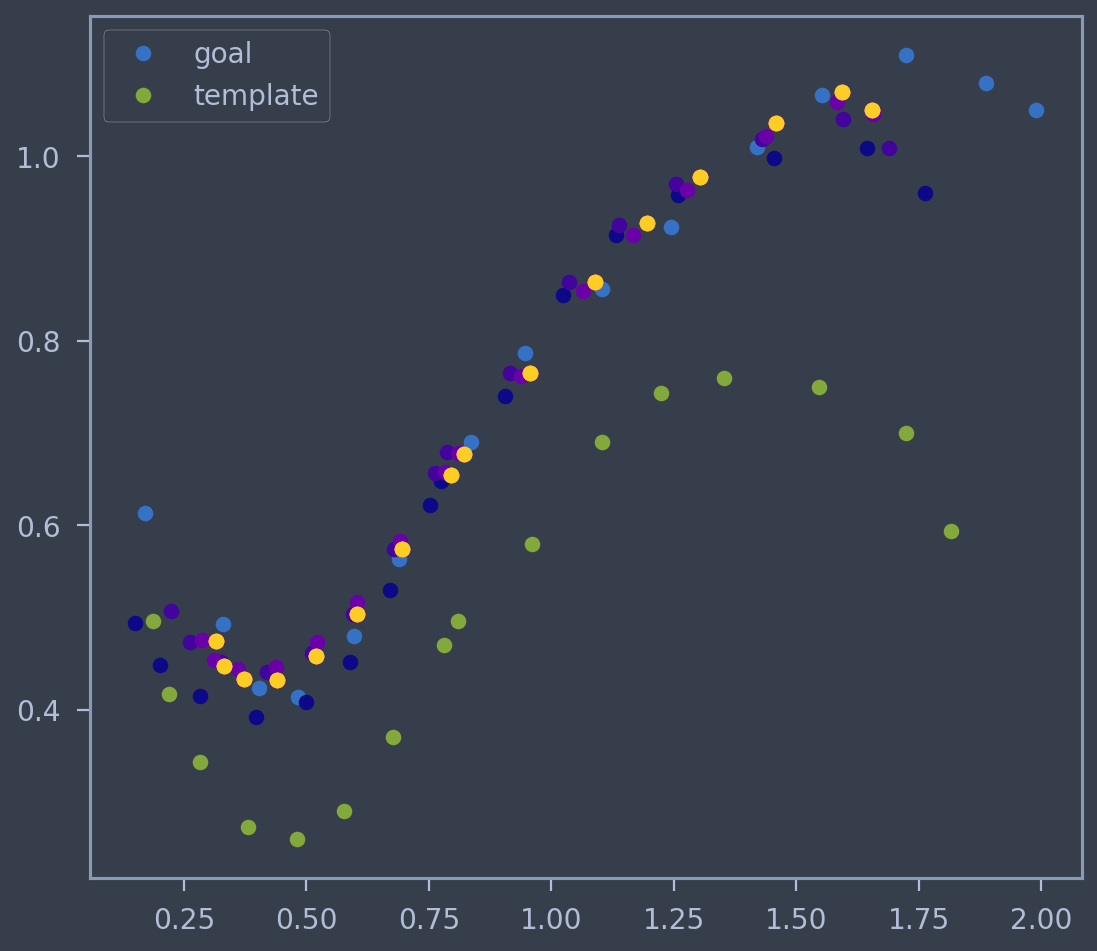

In [41]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib


class Eq:
    def __init__(self):
        self.row_indices = []
        self.column_indices = []
        self.values = []
        self.rhs = []
    
    def add_equation(self, w, rhs, pairs):
        row = len(self.rhs)
        for column, value in pairs:
            self.row_indices.append(row)
            self.column_indices.append(column)
            self.values.append(w * value)
        self.rhs.append(w * rhs)
    
    def matrices(self):
        return csr_matrix((self.values, (self.row_indices, self.column_indices))), np.array(self.rhs)
 

def parameter_index(i, row, column):
    return 6 * i + 3 * row + column


def step(template, edges, us, stiffness, distance_weight=1):
    eq = Eq()
    # distance costs
    for i, (v, u) in enumerate(zip(template, us)):
        for dim in range(2):
            eq.add_equation(distance_weight / 2, u[dim], [
                (parameter_index(i, dim, 0), v[0]),
                (parameter_index(i, dim, 1), v[1]),
                (parameter_index(i, dim, 2), 1)])

    # stiffness costs
    for e0, e1 in edges:
        for row in range(2):
            for column in range(3):
                eq.add_equation(stiffness, 1, [
                    (parameter_index(e0, row, column), +1),
                    (parameter_index(e1, row, column), -1)
                ])

    # solve
    A, b = eq.matrices()
    X = spsolve(A.T * A, A.T * b)
    
    # transform vertices
    for i, v in enumerate(template):
        for d in range(2):
            pts[i, d] = \
                X[parameter_index(i, d, 0)] * v[0] + \
                X[parameter_index(i, d, 1)] * v[1] + \
                X[parameter_index(i, d, 2)]
    return pts

n = 10
pts = np.copy(template)

cmap = matplotlib.colormaps['plasma']
plt.plot(goal[:, 0], goal[:, 1], 'o', label='goal')
plt.plot(template[:, 0], template[:, 1], 'o', label='template')
for i in range(10):
    t = i / n
    stiffness = 100*(1 - t)
    us = find_correspondances(pts, goal)
    pts = step(template, edges, us, stiffness=stiffness, distance_weight=0.1)
    plt.plot(pts[:, 0], pts[:, 1], 'o', color=cmap(t), alpha=1)
plt.legend(); None

## Let's leave this notebook
* 3D time!
* Nostaliga time

## Questions?

## Thank you!